# Research of the marketing strategy of the Procrastinate Pro+ application

Despite huge investments in advertising, the company has been suffering losses for the past few months. Our task is to understand the reasons and help the company to become a plus.

**Project Description**

In the course of this study, we will analyze data on current advertising expenses, sales and site visits

**The purpose of the investigation**

Determine the causes of the company's losses

**The essence of research**

To analyze the data, the results of which will help to understand the reasons for the financial failures of the company, as well as give recommendations on how to improve the marketing strategy to make a profit

**Research objectives**

Perform preprocessing of the source data, output and analyze business metrics. Form recommendations on a marketing strategy for the future

**Initial data**

Three tables are presented for the study, including:
A table with information about site visits
A table with information about orders
A table with information about advertising expenses

**This study will be divided into several parts**

1. [Loading data and preparing it for analysis](#Loading-data-and-preparing-it-for-analysis)
2. [Define functions for calculating and analyzing LTV, ROI, retention and conversion](#Define-functions-for-calculating-and-analyzing-LTV,-ROI,-retention-and-conversion)
3. [Research data analysis](#Research-data-analysis)
4. [Marketing research](#Marketing-research)
5. [Evaluation of the payback of advertising](#Evaluation-of-the-payback-of-advertising)
6. [Conclusions](#Conclusions)

### Loading data and preparing it for analysis

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

try:
    visits = pd.read_csv('D:/Документы/LinkedIn/7 Анализ бизнес-показателей/visits_info_short.csv')
    orders = pd.read_csv('D:/Документы/LinkedIn/7 Анализ бизнес-показателей/orders_info_short.csv')
    costs = pd.read_csv('D:/Документы/LinkedIn/7 Анализ бизнес-показателей/costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Let's bring the column names to a single style

In [3]:
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device',
                                'Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'})

Converting time data

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Checking the number of duplicates

In [5]:
visits.duplicated().sum()

0

Let's check for implicit duplicates of the columns region, device and channel

In [6]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [7]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [8]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

There are no implicit duplicates. Let's check the minimum and maximum dates. Are there any out-of-place values there. Also check that the end of the session is always later than the beginning.

In [9]:
display(visits['session_start'].min(),
        visits['session_start'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-31 23:59:23')

In [10]:
display(visits['session_end'].min(),
        visits['session_end'].max())

Timestamp('2019-05-01 00:07:06')

Timestamp('2019-11-01 01:38:46')

In [11]:
display(visits.query('session_end < session_start'))

,user_id,region,device,channel,session_start,session_end


The dates are fine. Let's look at the general information about the table.

In [12]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


It's all right.
Let's do the same with two other data frames.

In [13]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [14]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

In [15]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [16]:
orders.duplicated().sum()

0

In [17]:
display(orders['event_dt'].min(),
        orders['event_dt'].max())

Timestamp('2019-05-01 00:28:11')

Timestamp('2019-10-31 23:56:56')

In [18]:
orders.query('revenue <= 0')

,user_id,event_dt,revenue


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [20]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [21]:
costs = costs.rename(columns={'Channel': 'channel'})

In [22]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [23]:
costs.duplicated().sum()

0

In [24]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [25]:
display(costs['dt'].min(),
        costs['dt'].max())

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

In [26]:
costs.query('costs <= 0')

,dt,channel,costs


In [27]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


The date frames are prepared for analysis. There are no omissions, duplicates, etc. in it

### Define functions for calculating and analyzing LTV, ROI, retention and conversion

In [28]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({  'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index())
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index())

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',)

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [29]:
def get_retention(profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = (df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

In [30]:
def get_conversion(profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index())

    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

In [31]:
def get_ltv(profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
 
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')

        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'}))
 
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'}))

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,)  # ROI dynamics table

In [32]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [33]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])

    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    ax3 = plt.subplot(2, 2, 3)

    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]

    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of retention of paying users on the {}th day'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)

    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of retention of non-paying users on the {}th day'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

In [34]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])

    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of user conversion on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [35]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])

    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])

    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)

    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of LTV users on the {}th day'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of the cost of engagement users')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)

    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Date of engagement')
    plt.title('Dynamics of user ROI on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

### Research data analysis

- Create user profiles. Determine the minimum and maximum dates for attracting users.
- Find out which countries users come to the app from and which country accounts for the most paying users. Build a table showing the number of users and the share of payers from each country.
- Find out which devices are used by customers and which devices are preferred by paying users. Build a table showing the number of users and the percentage of payers for each device.
- Study the advertising sources of attraction and determine the channels from which the most paying users came. Build a table reflecting the number of users and the share of payers for each attraction channel.

After each point, we will formulate conclusions.

#### Create user profiles. Determine the minimum and maximum dates for attracting users.

In [36]:
profiles = get_profiles(visits, orders, costs)
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
display(profiles.head(), min_date, max_date)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

#### Find out which countries users come to the app from and which country accounts for the most paying users. Build a table showing the number of users and the share of payers from each country.

In [37]:
region_payer = profiles.groupby('region').agg({'payer' : ['count', 'mean']})
region_payer.columns = ['count', 'mean %']
region_payer['mean %'] = round(region_payer['mean %'] * 100, 2)
region_payer.sort_values(by='mean %', ascending=False)

,count,mean %
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


Users come from 4 countries.
The largest share of paying users is from the USA. Almost 7%. Also, it is from the USA that the most users come

#### Find out which devices are used by customers and which devices are preferred by paying users. Build a table showing the number of users and the percentage of payers for each device.

In [38]:
device_payer = profiles.groupby('device').agg({'payer' : ['count', 'mean']})
device_payer.columns = ['count', 'mean %']
device_payer['mean %'] = round(device_payer['mean %'] * 100, 2)
display(device_payer.sort_values(by='mean %', ascending=False),
        device_payer.sort_values(by='count', ascending=False))

,count,mean %
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


,count,mean %
device,,
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05
Mac,30042,6.36


The largest share of paying users is sitting with MacBooks and iPhones. They have almost the same percentage of payment. According to the number of users, the iPhone is by a large margin.

#### Study the advertising sources of attraction and determine the channels from which the most paying users came. Build a table reflecting the number of users and the share of payers for each attraction channel.

In [39]:
channel_payer = profiles.groupby('channel').agg({'payer' : ['count', 'mean']})
channel_payer.columns = ['count', 'mean %']
channel_payer['mean %'] = round(channel_payer['mean %'] * 100, 2)
display(channel_payer.sort_values(by='mean %', ascending=False).head(5),
        channel_payer.sort_values(by='count', ascending=False).head(5))

,count,mean %
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91


,count,mean %
channel,,
organic,56439,2.06
FaceBoom,29144,12.20
TipTop,19561,9.60
OppleCreativeMedia,8605,2.71
LeapBob,8553,3.06


The main market for the company at the moment is the USA. It is from the states that the largest flow of customers comes. In addition, it is there that the largest proportion of paying customers. This correlates with which platform the most customers come from. In this case, the Iphone and Mac, the percentage of which, as it known, is much higher in the United States than in other countries. As for advertising channels, it is worth highlighting FaceBoom. This is the leader, both in terms of the number and quality of attracted users. TipTop also appears in both ratings of top sites. I believe that FaceBoom and Tip Top are hiding under these "code" names. That is, the main source of attracting users are social networks. This situation could happen for two reasons - either the advertising was very well targeted, or there was just a lot of it. Let's see what further research will show.

### Marketing research

- Calculate the total amount of marketing expenses.
- Find out how the expenses are distributed by advertising sources, that is, how much money was spent on each source.
- To build a visualization of the dynamics of changes in expenses over time (by weeks and months) for each source.
- Find out how much it cost on average to attract one user (CAC) from each source.

After each point, we will formulate a short conclusion.

#### Calculate the total amount of marketing expenses.

In [40]:
profiles['acquisition_cost'].sum().round(2)

105497.3

Almost 105 and a half thousand dollars were spent on advertising

#### Find out how the expenses are distributed by advertising sources, that is, how much money was spent on each source.

In [41]:
display(profiles.groupby('channel').agg({'acquisition_cost' : 'sum'})
        .sort_values(by='acquisition_cost', ascending=False))

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


The most money have spent on Tip Top. FaceBoom, through which the largest number of customers came, is second in the list.

#### To build a visualization of the dynamics of changes in expenses over time (by weeks and months) for each source.

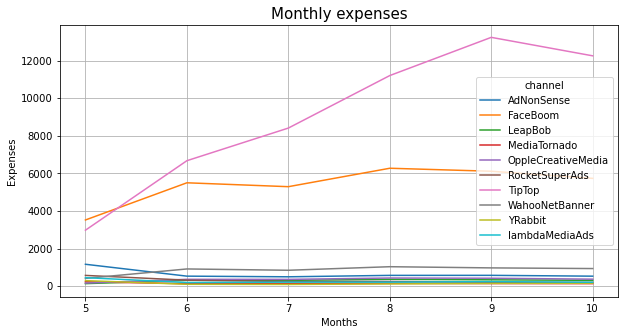

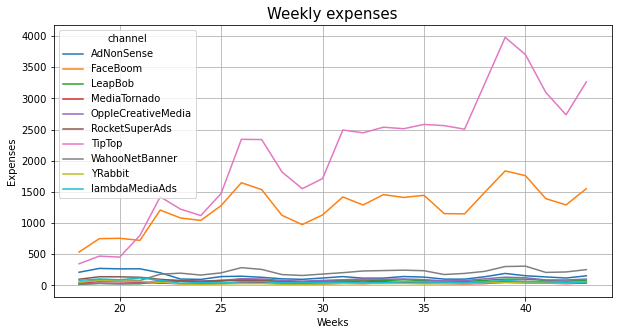

In [42]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(10, 5))
plt.title("Monthly expenses",fontsize=15)
plt.xlabel("Months",fontsize=10)
plt.ylabel("Expenses",fontsize=10)
plt.show();

costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(10, 5))
plt.title("Weekly expenses",fontsize=15)
plt.xlabel("Weeks",fontsize=10)
plt.ylabel("Expenses",fontsize=10)
plt.show();

TipTop and FaceBoom are also in the top in terms of spending on them. Moreover, the costs grew over time

#### Find out how much it cost on average to attract one user (CAC) from each source.

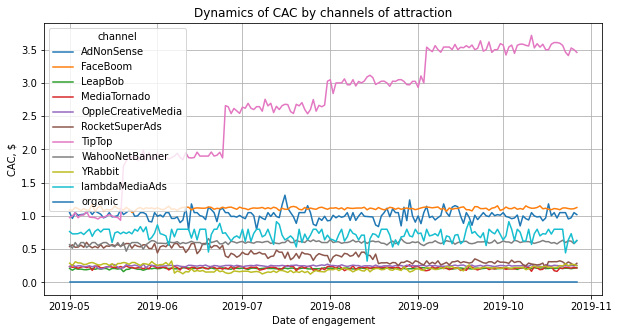

In [43]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Date of engagement')
plt.title('Dynamics of CAC by channels of attraction')
plt.show()

The cost of attracting one user through TipTop is much higher than through all other sources.

Additionally, we will calculate the average CAC for each channel

In [44]:
profiles.pivot_table(
    columns='channel',
    values='acquisition_cost',
    aggfunc='mean'
).T.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


FaceBoom and Tip Top cost the most to attract a single customer. And if FaceBoom remains about the same figures as the rest of the sources, then the cost of a client from TipTop is 2.5 times higher than that of the nearest "competitor"

We will also calculate the average CAC for the project

In [45]:
round(profiles['acquisition_cost'].sum() / profiles['acquisition_cost'].count(), 3)

0.703

Of the indicators of marketing research, two indicators are the most interesting - advertising costs and CAC through distribution channels.
From these two graphs, a strong increase in spending is visible from two sources - FaceBoom and TipTop. At the same time, if you look at the cost of attracting CAC per user, it turns out that CAC on FaceBoom has not changed, but TipTop has grown as well as its costs. Thus, it can be concluded that investments in Tip Top were extremely inefficient.

### Evaluation of the payback of advertising

Using LTV, ROI and CAC charts, we will analyze the payback of advertising. We will assume that November 1, 2019 is on the calendar, and the business plan stipulates that users should pay off no later than two weeks after the attraction.

- Analyze the payback of advertising using LTV and ROI graphs, as well as LTV, CAC and ROI dynamics graphs.
- Check the user conversion and the dynamics of its changes. We will do the same with user retention. Let's build and study conversion and retention charts.
- Analyze the payback of advertising by device, country and advertising channels. Let's plot LTV and ROI graphs, as well as LTV, CAC and ROI dynamics graphs.

We will answer the following questions:
- Does advertising aimed at attracting users in general pay off?
- Which devices, countries and advertising channels can have a negative impact on the payback of advertising?
- What can cause payback problems?

We will write a conclusion, describe the possible causes of the detected problems and interim recommendations for the advertising department.

#### Analyze the payback of advertising using LTV and ROI graphs, as well as LTV, CAC and ROI dynamics graphs.

In [46]:
observation_date = datetime(2019, 11, 1).date()  # moment of analysis
horizon_days = 14  # horizon of analysis
profiles = profiles.query('channel != "organic"')

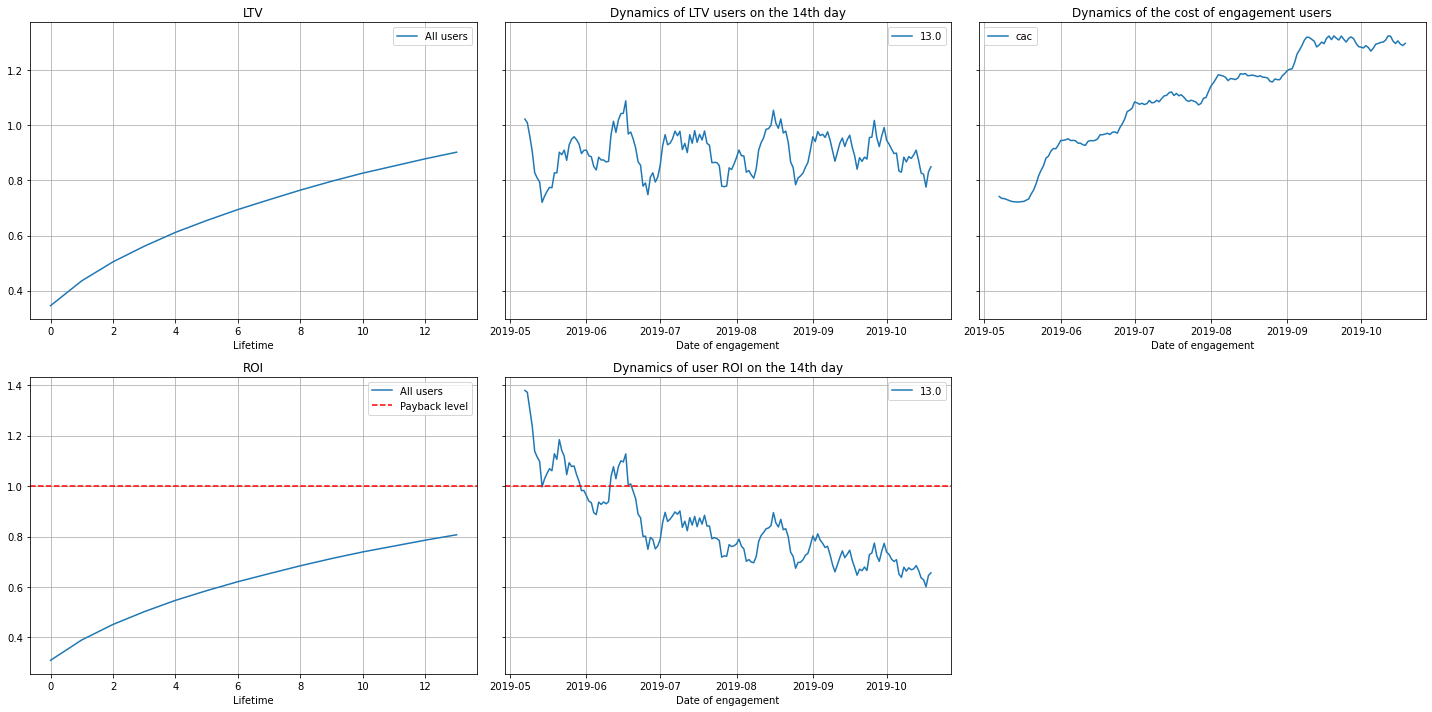

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV is stable. Both in life time and in dynamics. At the same time, the CAC is constantly growing, which, in turn, affects the ROI. Thus, it can be concluded that the increase in advertising costs did not lead to the expected increase in LTV.

#### Check the user conversion and the dynamics of its changes. We will do the same with user retention. Let's build and study conversion and retention charts.

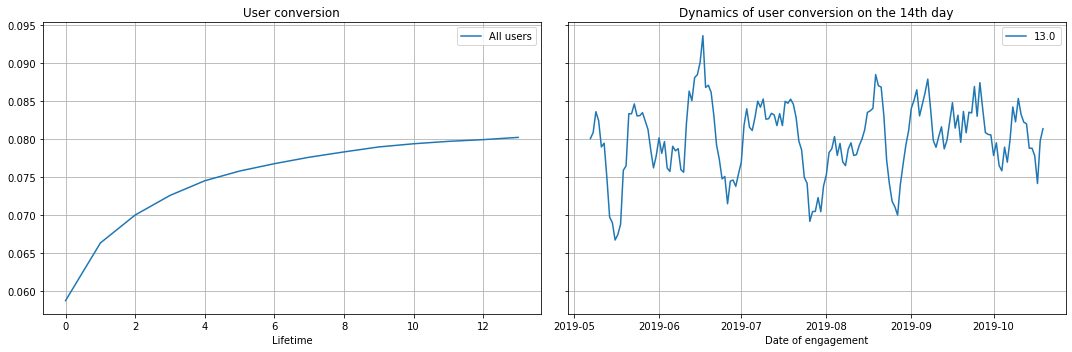

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

The conversion rate practically does not increase after the first week. The conversion rate for the 14th day in dynamics after the increase in expenses has not changed much.

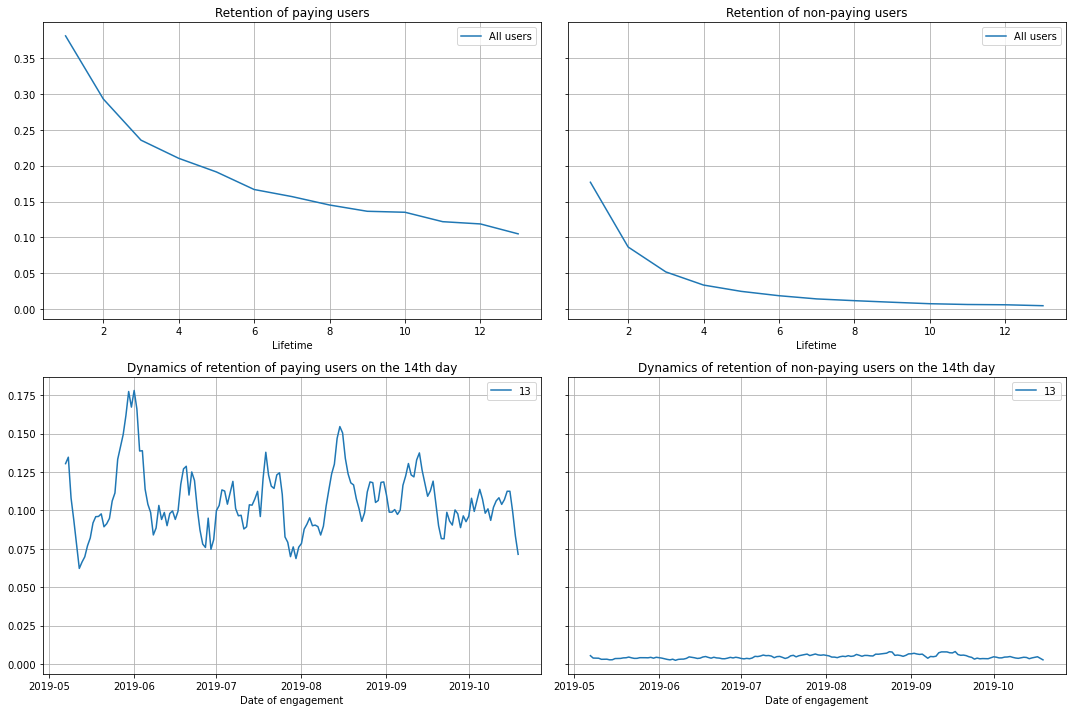

In [49]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days)

In my opinion, based on the graphs, the retention of non-paying users is one of the main problems of the application. On the 14th day, the retention rate varies about 1%, which is very small. In general, the increase in marketing expenses did not affect the long-term performance in any way

#### Analyze the payback of advertising by device, country and advertising channels. Let's plot LTV and ROI graphs, as well as LTV, CAC and ROI dynamics graphs.

##### Analyze the payback of advertising by device

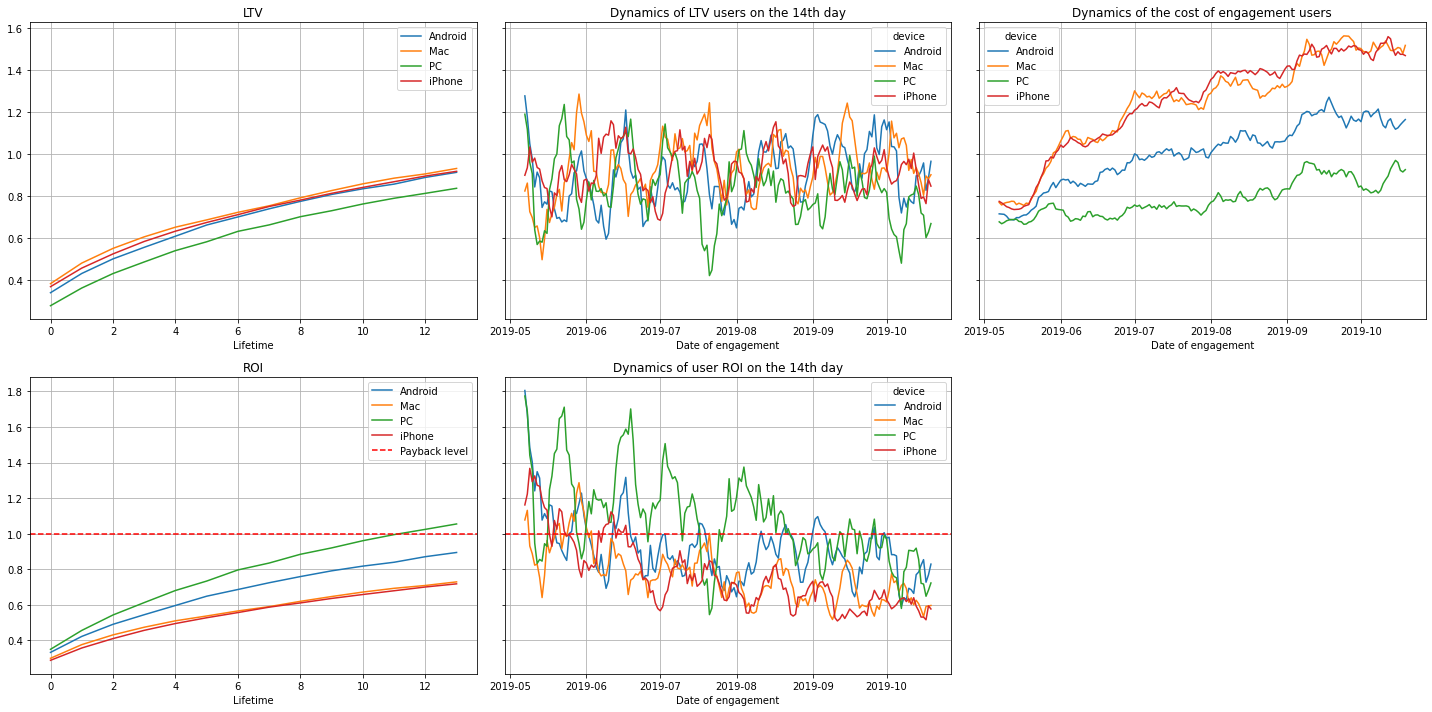

In [50]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

For devices, the main conclusion is that the cost of attracting on PC and Android platforms is on the threshold of payback. And Mac and iPhone don't pay off at all. And the main problem here is the cost of attraction. After its sharp growth, the payback indicators went into negative territory. PC pays off

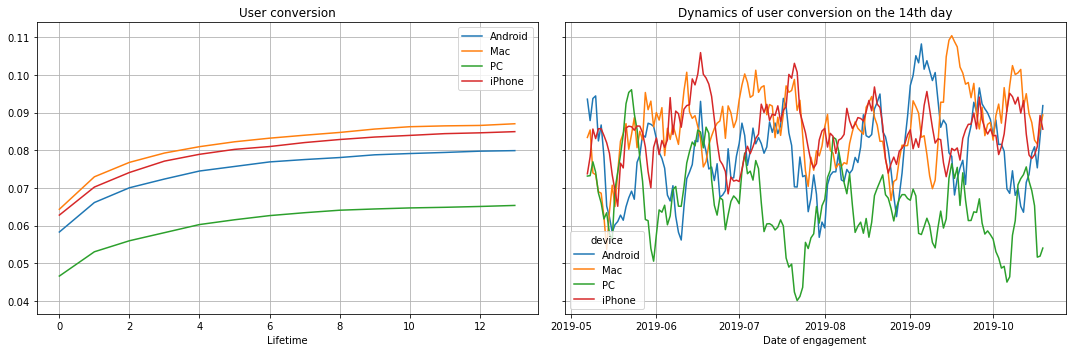

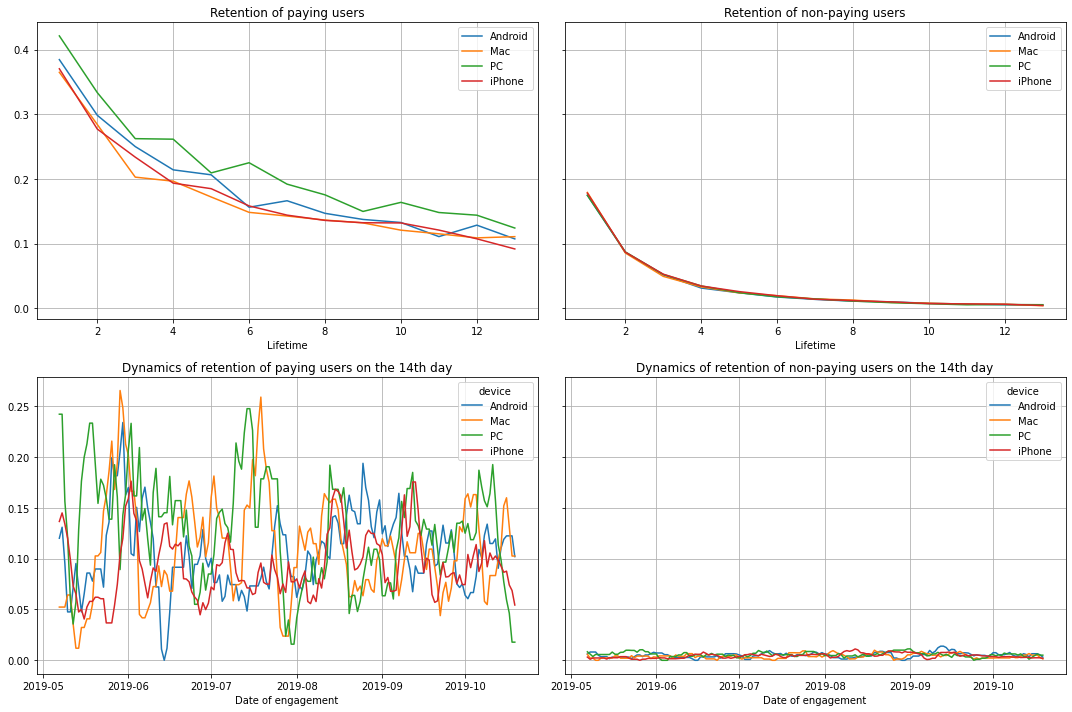

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 
plt.show()

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, horizon_days)

##### Analyze the payback of advertising by country

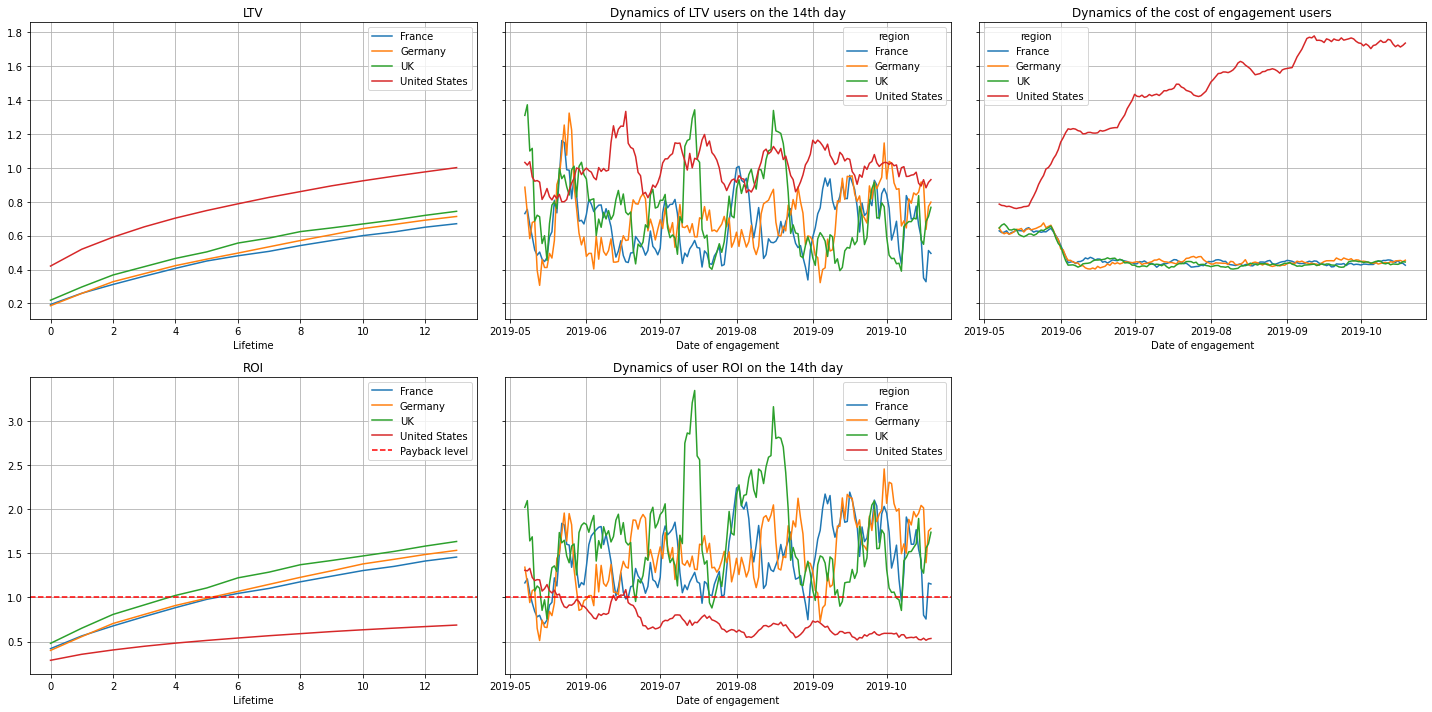

In [52]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

From the breakdown by country, it can be seen that the increase in spending occurred in the United States. At the same time, LTV in the USA grew slightly.

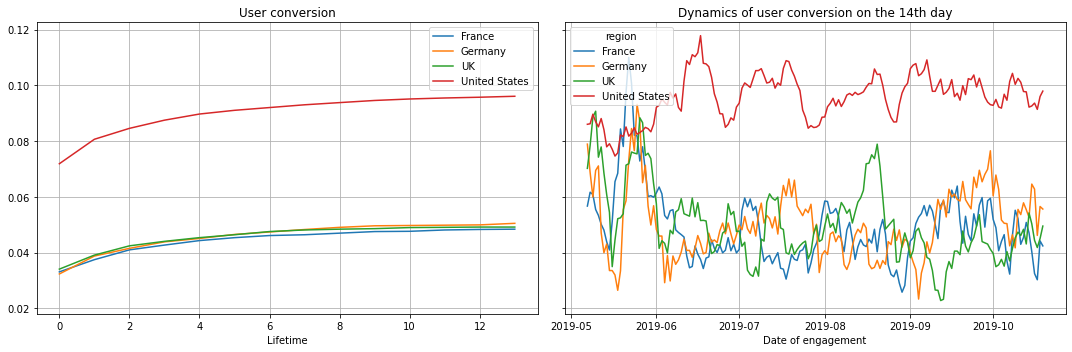

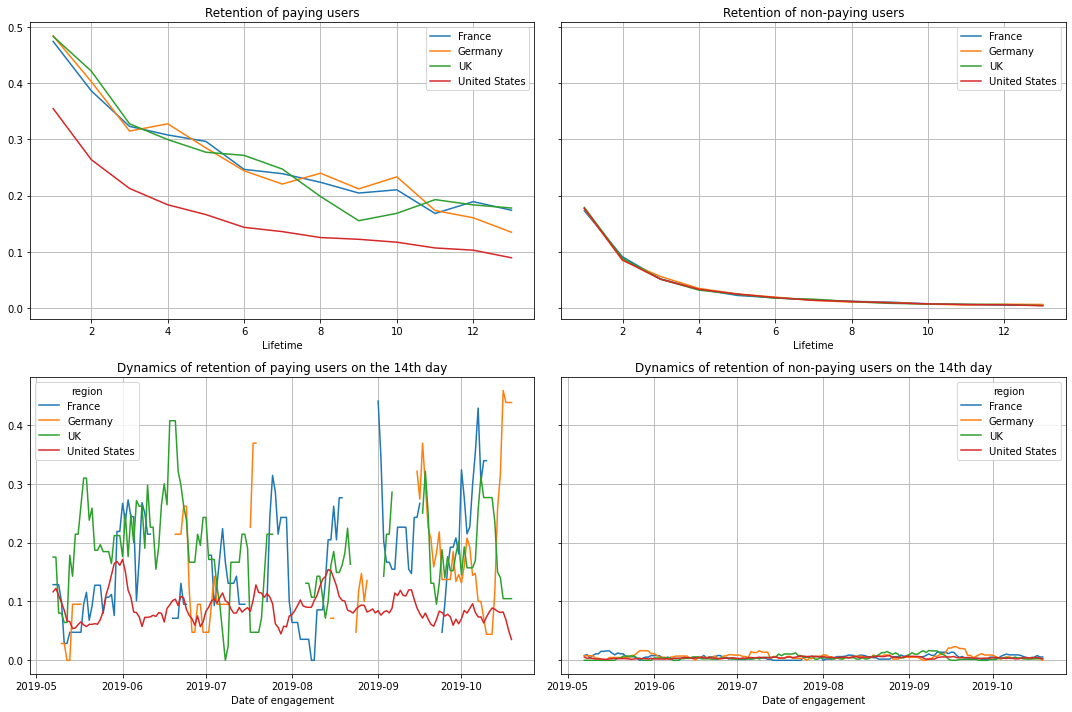

In [53]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 
plt.show()

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention, retention_history, horizon_days)

##### Analyze the payback of advertising by advertising channels

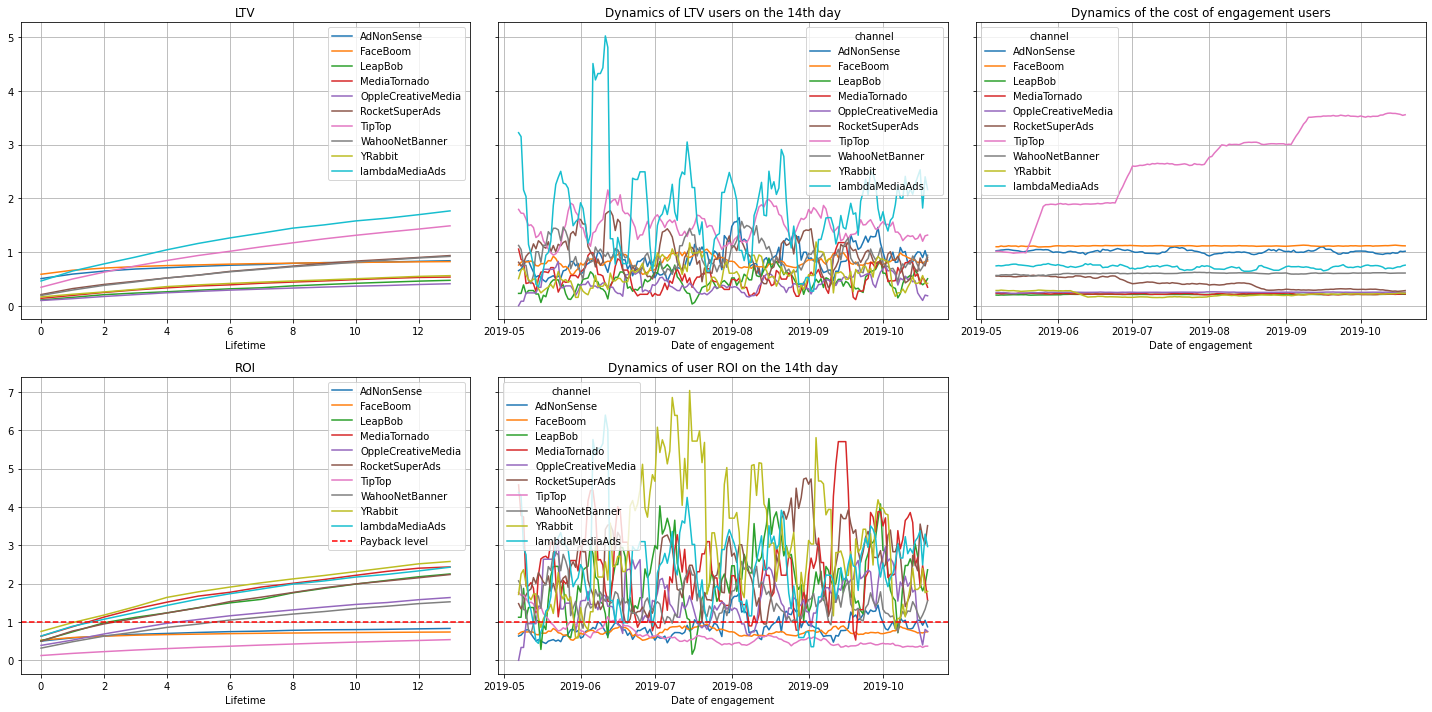

In [54]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

The main "culprit" of the increase in expenses is Tip Top. It was through this channel that there was an increase in spending in June and it is also the worst in terms of ROI.

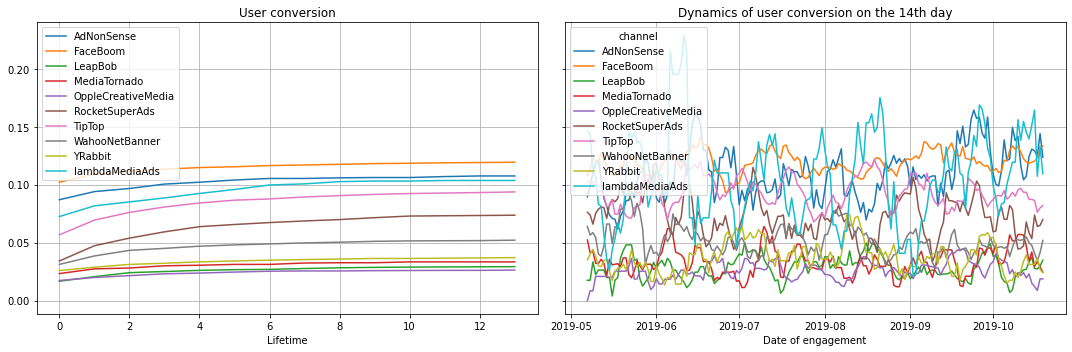

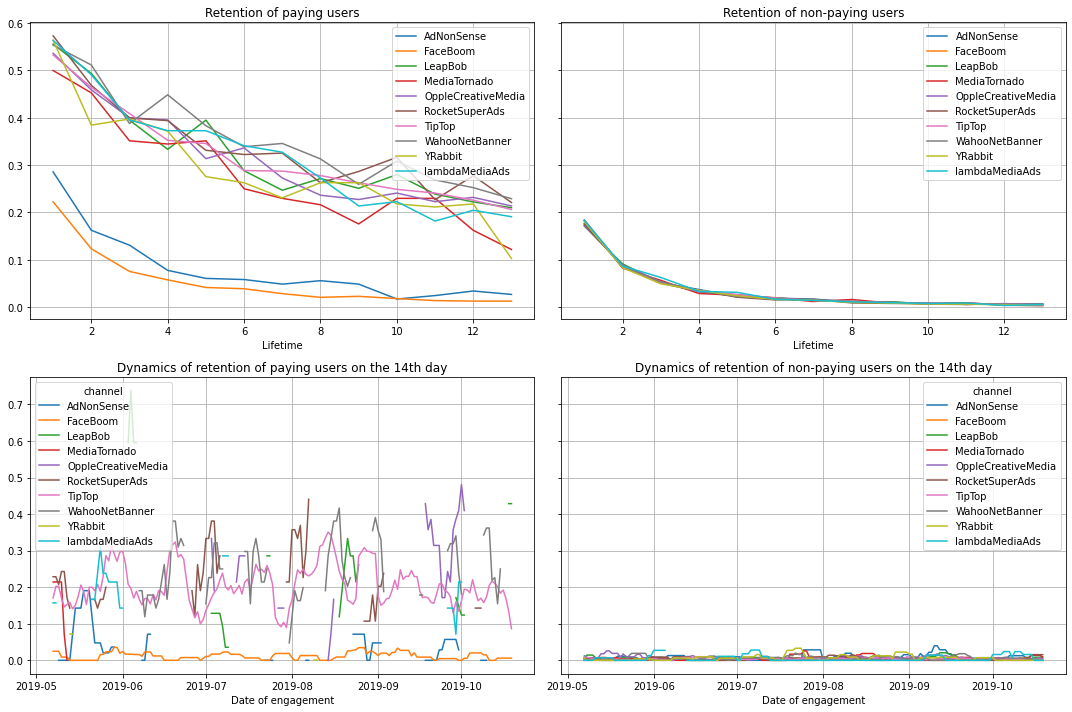

In [55]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 
plt.show()

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days)

### Conclusions

There are several reasons for an unsuccessful advertising campaign at once:

1. Too much cost growth on the TipTop platform, which did not pay off. Due to high costs, despite a consistently high flow of customers, TipTop's ROI turned out to be the lowest of all advertising sources.

2. Take into account the low retention rate of non-paying users. Regardless of any parameters, the indicator is kept at the level of 1%.

3. Low retention rate of paying users from AdNonSense and Faceboom channels.

4. Low retention rate of paying users in the USA.

Recommendations:

1. Reduce advertising costs in TipTop

2. Work out the percentage of retention of non-paying users. Perhaps the application does not have a free version at all, so that non-paying users can evaluate the advantages / convenience of using the service

3. Increase the retention rate of paying users from AdNonSense and Faceboom channels. Given the large number of users coming from these platforms and the high LTV, an increase in the retention rate would significantly increase revenue and bring ROI to plus

4. Reduce advertising costs in the USA, as their increase did not have any positive effect

5. Arrange an "exchange of experience" between two regions - the USA and Europe. In the USA, conversion and LTV are better, but the retention rate is low. In Europe, it's the opposite. See a similar situation at the level of platforms that are commonly used in the respective regions.

6. Increase conversion and LTV of PC users. At the moment, when splitting users into device types, a PC is the only type in the positive ROI zone. Despite the fact that the conversion and LTV of PC users lags behind other platforms